# House price prediction

#### Importing libraries & loading the data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [3]:
# Compiling train & test data

def con_cat(train, test):
    df1, df2 = train.copy(), test.copy()
    df1["group"] = "train"
    df2["group"] = "test"
    
    return pd.concat([df1, df2], axis=0, ignore_index=True)

df = con_cat(train, test)
df.drop("Id", axis=1, inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,group
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train


#### Exploratory data analysis

In [4]:
# Categorising columns

def find_col_types(data, ord_th):
    cat_cols = data.select_dtypes("object").columns.to_list()
    num_cols = data.select_dtypes("number").columns.to_list()
    
    ordinals = [col for col in num_cols if data[col].nunique() < ord_th]
    num_cols = [col for col in num_cols if col not in ordinals]
    
    return num_cols, cat_cols, ordinals

num_cols, cat_cols, ordinals = find_col_types(df, 20)

print("Numerical cols:", num_cols, "\n")
print("Categorical cols:", cat_cols, "\n")
print("Ordinal cols:", ordinals)

Numerical cols: ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SalePrice'] 

Categorical cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'group'] 

Ordinal cols: ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFul

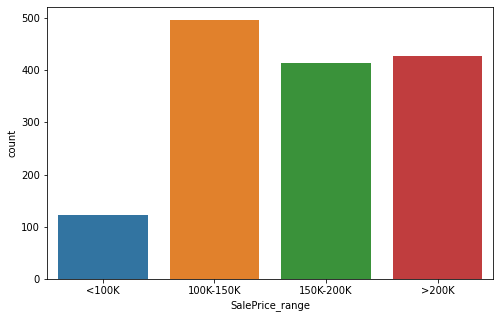

In [5]:
# Categorising Saleprice data

sale_bin = np.array([-np.inf*1000, 100000, 150000, 200000, np.inf*1000])
sale_label = ["<100K", "100K-150K", "150K-200K", ">200K"]

df['SalePrice_range'] = pd.cut(df['SalePrice'], bins=sale_bin, labels=sale_label)
df['SalePrice_range'].value_counts()

plt.figure(figsize=(8,5))
sns.countplot(x='SalePrice_range', data=df)
plt.show()

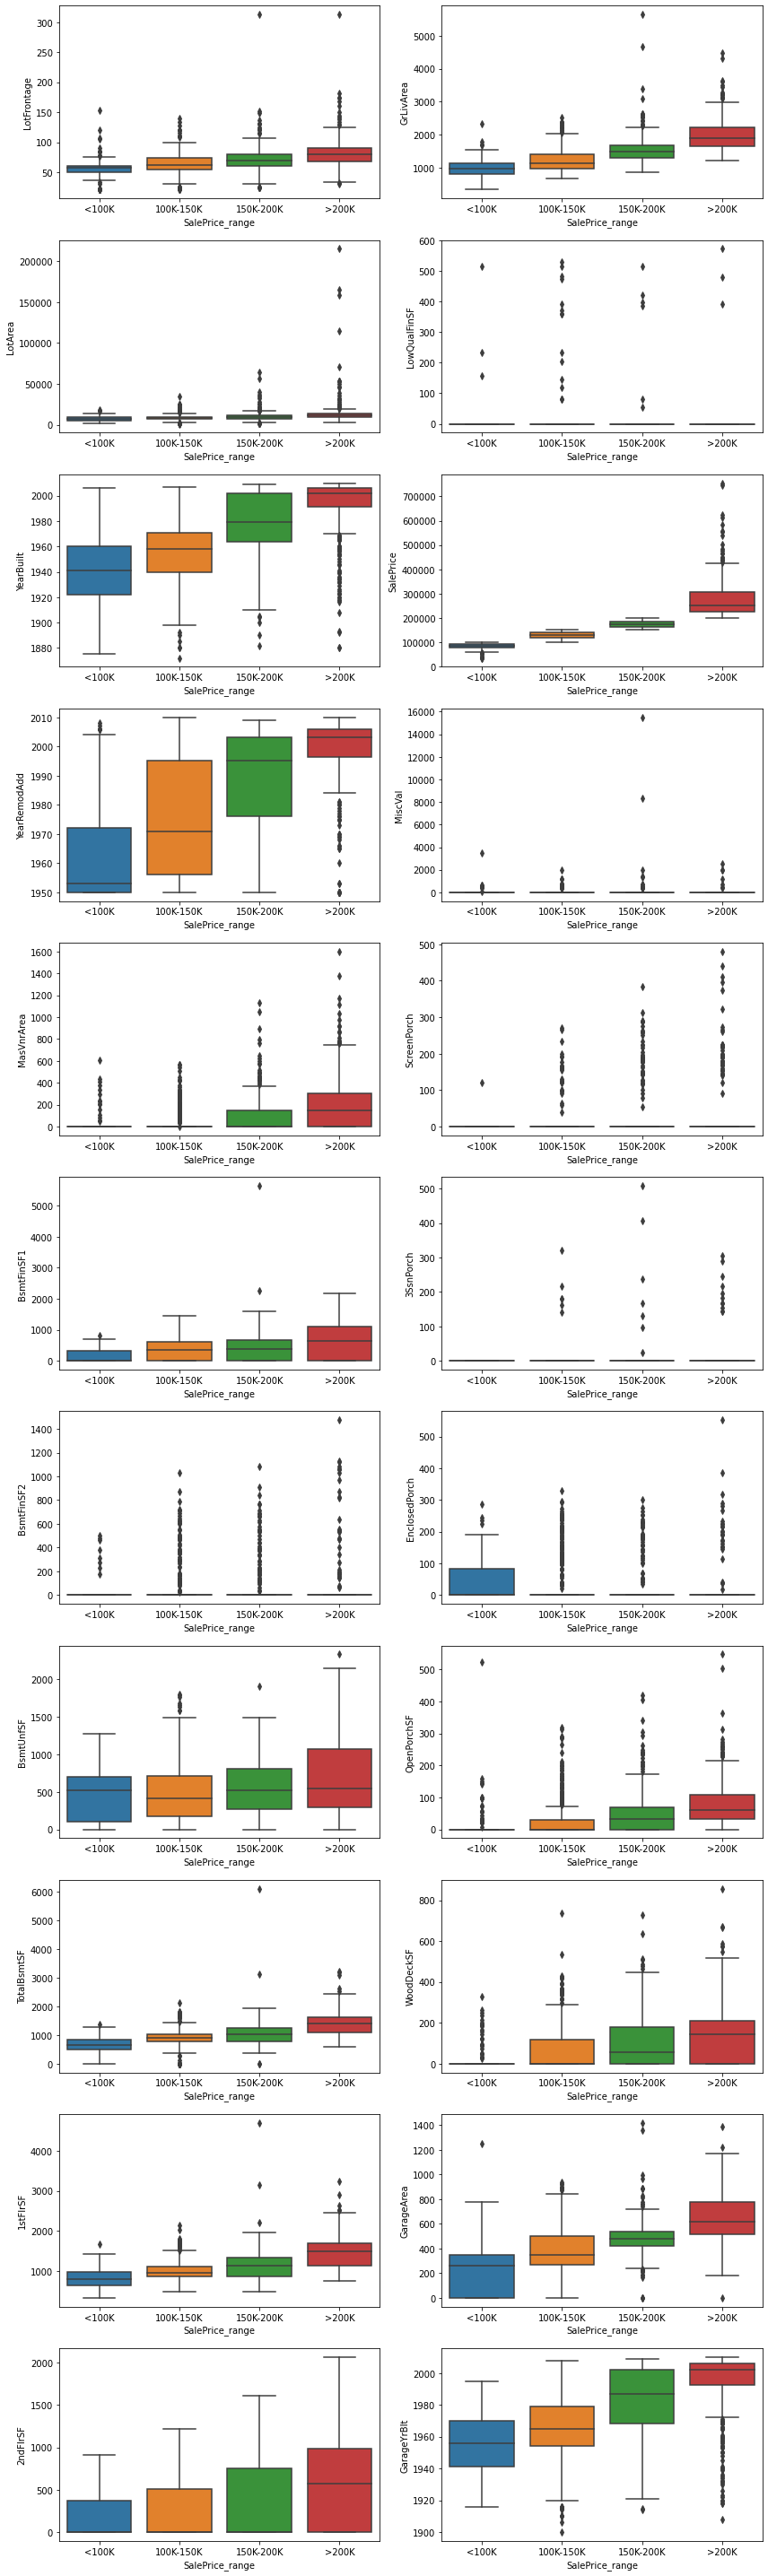

In [6]:
# Data visualization with respect to Saleprice_range

fig, axes = plt.subplots(11,2, figsize=(12,40))

for i,col in enumerate(num_cols):
    if i<11:
        sns.boxplot(x='SalePrice_range', data=df, y=col, ax=axes[i,0])
    else:
        sns.boxplot(x='SalePrice_range', data=df, y=col, ax=axes[12-i,1])
        
    plt.tight_layout()

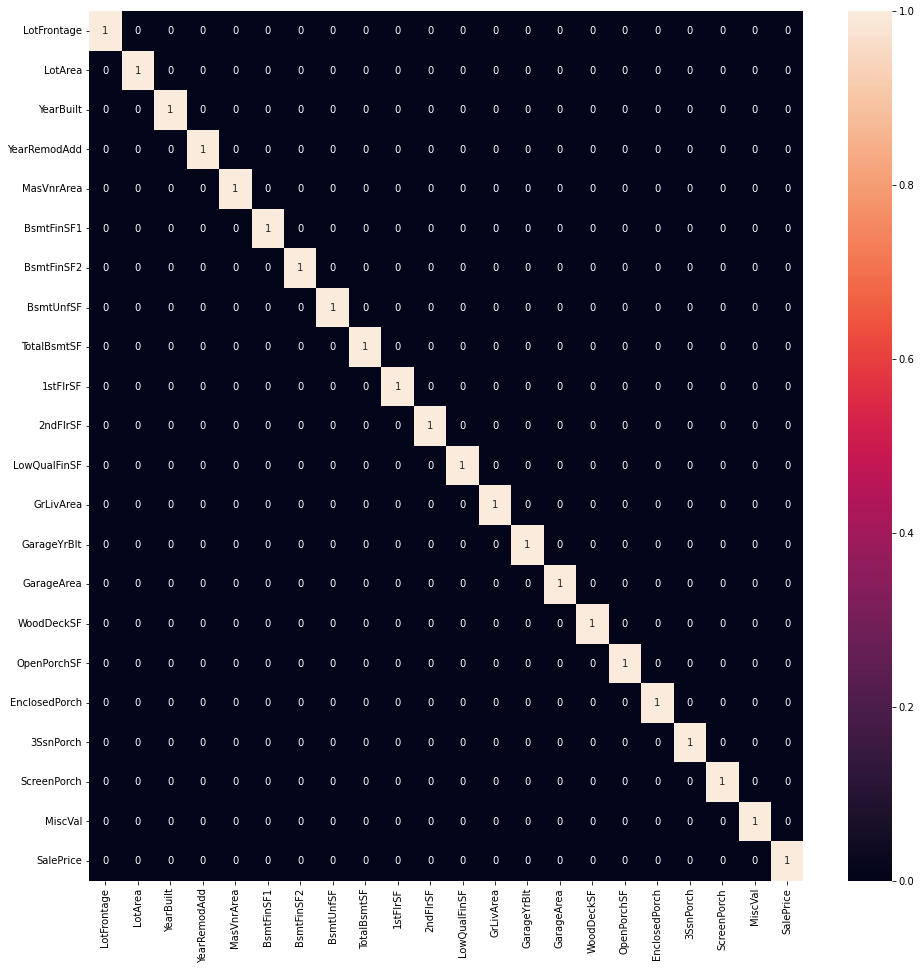

In [7]:
# Correlation matrix

corr_matrix = df[num_cols].corr()
high_corr = corr_matrix.abs()>0.9

plt.figure(figsize=(16,16))
sns.heatmap(high_corr, annot=True)
plt.show()

#### Removing outliers

In [8]:
def outlier_detection (df, cols, take_care_outliers=False, print_outliers=False, q_1=0.25, q_3=0.75):
    temp = pd.DataFrame()
    data = df.copy()
    
    for col in cols:
        q1 = df[col].quantile(q_1)
        q3 = df[col].quantile(q_3)
        IQR = q3 - q1
        up = q3 + 1.5*IQR
        low = q1 - 1.5*IQR
        
        temp.loc[col,"Min"] = round(data[col].min())
        temp.loc[col,"Low"] = round(low)
        temp.loc[col,"Mean"] = round(data[col].mean())
        temp.loc[col,"Median"] = round(data[col].median())
        temp.loc[col,"Upper limit"] = round(up)
        temp.loc[col,"Max"] = round(data[col].max())
        temp.loc[col,"Outlier"] = "Min-max-outlier" if (data[col].max() > up) and (data[col].min()) else ("Max-outlier" if data[col].max() > up \
                                                                                                    else ("Min-outlier" if data[col].min() < low else "No"))
        if take_care_outliers:
            data.loc[data[col]>up, col] = round(up-1)
            data.loc[data[col]<low, col] = round(low+1)
            
    if take_care_outliers:
        if print_outliers:
            return temp
        return data
    if print_outliers:
        return temp

In [9]:
outlier_detection(df, num_cols,print_outliers=True, q_1=0.01, q_3=0.99)

,Min,Low,Mean,Median,Upper limit,Max,Outlier
LotFrontage,21.0,-151.0,69.0,68.0,308.0,313.0,Min-max-outlier
LotArea,1300.0,-45358.0,10168.0,9453.0,80077.0,215245.0,Min-max-outlier
YearBuilt,1872.0,1738.0,1971.0,1973.0,2170.0,2010.0,No
YearRemodAdd,1950.0,1862.0,1984.0,1993.0,2098.0,2010.0,No
MasVnrArea,0.0,-1157.0,102.0,0.0,1928.0,1600.0,No
BsmtFinSF1,0.0,-2453.0,441.0,368.0,4088.0,5644.0,Max-outlier
BsmtFinSF2,0.0,-1312.0,50.0,0.0,2187.0,1526.0,No
BsmtUnfSF,0.0,-2665.0,561.0,467.0,4441.0,2336.0,No
TotalBsmtSF,0.0,-3297.0,1052.0,990.0,5496.0,6110.0,Max-outlier
1stFlrSF,334.0,-2132.0,1160.0,1082.0,4940.0,5095.0,Min-max-outlier


In [10]:
df2 = outlier_detection(df, num_cols, take_care_outliers=True, print_outliers=False, q_1=0.01, q_3=0.99)

In [11]:
outlier_detection(df2, num_cols, print_outliers=True, q_1=0.01, q_3=0.99)

,Min,Low,Mean,Median,Upper limit,Max,Outlier
LotFrontage,21.0,-151.0,69.0,68.0,308.0,307.0,No
LotArea,1300.0,-45358.0,10054.0,9453.0,80077.0,80076.0,No
YearBuilt,1872.0,1738.0,1971.0,1973.0,2170.0,2010.0,No
YearRemodAdd,1950.0,1862.0,1984.0,1993.0,2098.0,2010.0,No
MasVnrArea,0.0,-1157.0,102.0,0.0,1928.0,1600.0,No
BsmtFinSF1,0.0,-2453.0,441.0,368.0,4088.0,4087.0,No
BsmtFinSF2,0.0,-1312.0,50.0,0.0,2187.0,1526.0,No
BsmtUnfSF,0.0,-2665.0,561.0,467.0,4441.0,2336.0,No
TotalBsmtSF,0.0,-3297.0,1052.0,990.0,5496.0,5495.0,No
1stFlrSF,334.0,-2132.0,1160.0,1082.0,4940.0,4939.0,No


#### Missing value treatment

In [12]:
# Missing value treatment - Numerical cols

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df2_new = df2.drop(["SalePrice","SalePrice_range"], axis=1)

num_cols = [col for col in df2_new.select_dtypes(["int64","float64"])]

# If you want to impute for the missing values in any one column
# missing_mask = df2_new['LotFrontage'].isnull()

temp_df = df2_new.copy()

imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_values = imputer.fit_transform(temp_df[num_cols])

df2_new.loc[:,num_cols] = imputed_values
df2_new.head()

# If you want to impute for the missing values in any one column
# df2_new.loc[missing_mask,"LotFrontage"] = imputed_values[missing_mask,1]
# df2_new.isnull().sum()


/tmp/ipykernel_279/3950447129.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df2_new.loc[:,num_cols] = imputed_values


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,group
0,60.0,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,2.0,2008.0,WD,Normal,train
1,20.0,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,5.0,2007.0,WD,Normal,train
2,60.0,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,9.0,2008.0,WD,Normal,train
3,70.0,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,NaN,NaN,NaN,0.0,2.0,2006.0,WD,Abnorml,train
4,60.0,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,12.0,2008.0,WD,Normal,train


In [13]:
target_feat = df2[["SalePrice","SalePrice_range"]]
df3 = pd.concat([df2_new, target_feat], axis=1)
df3.shape

(2919, 82)

In [14]:
# Missing value treatment - Categorical columns

df3[cat_cols] = df3[cat_cols].fillna("None")
df3.isnull().sum()

MSSubClass            0
MSZoning              0
LotFrontage           0
LotArea               0
Street                0
                   ... 
SaleType              0
SaleCondition         0
group                 0
SalePrice          1459
SalePrice_range    1459
Length: 82, dtype: int64

#### Feature selection

In [15]:
# Remove columns where the distribution of one kind of data > 95%

drop_cols = []
all_cols = df3.columns

for col in all_cols:
    rank1 = (df3[col].value_counts().sort_values(ascending=False) / len(df)*100).iloc[0]
    if rank1 > 95:
        drop_cols.append(col)

drop_cols

['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'LowQualFinSF',
 'KitchenAbvGr',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'MiscFeature',
 'MiscVal']

In [16]:
print(df3.shape,"\n")
df3.drop(columns=drop_cols, axis=1, inplace=True)
print(df3.shape,"\n")

(2919, 82) 

(2919, 69) 



In [17]:
# Clubbing few columns together

df3['TotalArea'] = df3['TotalBsmtSF'] + df3['GrLivArea']

df3['TotalBathrooms'] = df3['FullBath'] + df3['HalfBath']*0.5 + df3["BsmtHalfBath"]*0.5 + df3["BsmtFullBath"]

df3['TotalRooms'] = df3['BedroomAbvGr'] + df3['TotRmsAbvGrd']

df3['TotalPorchArea'] = df3['OpenPorchSF'] + df3['EnclosedPorch'] + df3["ScreenPorch"] + df3["WoodDeckSF"]

df3['Hasgarrage'] = [1 if gar>0 else 0 for gar in df3["GarageYrBlt"]]

df3['Overal'] = df3['OverallQual'] + df3['OverallCond']

In [18]:
df3.drop(['TotalBsmtSF','GrLivArea','FullBath','HalfBath',"BsmtHalfBath","BsmtFullBath",'BedroomAbvGr','TotRmsAbvGrd','OpenPorchSF','EnclosedPorch', \
          "ScreenPorch","WoodDeckSF","GarageYrBlt",'OverallQual','OverallCond'], axis=1, inplace=True)
df3.shape

(2919, 60)

In [19]:
# Target feature

target = df3[["SalePrice"]]

In [20]:
df4 = df3.drop(["SalePrice", "SalePrice_range", "group"], axis=1)
df4.shape

(2919, 57)

In [21]:
# Preparing categorical data

all_cols_new = df4.select_dtypes("object").columns

for col in all_cols_new:
    rare = df4[col].value_counts().sort_values(ascending=False)/len(df4) < 0.05
    rare_names = rare[rare].index.tolist()
    df4.loc[df4[col].isin(rare_names),col] = 'Rare'

In [45]:
new_cat_col = df4.select_dtypes("object").columns

for i in new_cat_col:
    print(df4[i].value_counts())
    print("======================================================")

RL      2265
RM       460
Rare     194
Name: MSZoning, dtype: int64
None    2721
Rare     198
Name: Alley, dtype: int64
Reg     1859
IR1      968
Rare      92
Name: LotShape, dtype: int64
Lvl     2622
Rare     297
Name: LandContour, dtype: int64
Inside     2133
Corner      511
CulDSac     176
Rare         99
Name: LotConfig, dtype: int64
Rare       1112
NAmes       443
CollgCr     267
OldTown     239
Edwards     194
Somerst     182
NridgHt     166
Gilbert     165
Sawyer      151
Name: Neighborhood, dtype: int64
Norm     2511
Rare      244
Feedr     164
Name: Condition1, dtype: int64
1Fam      2425
Rare       267
TwnhsE     227
Name: BldgType, dtype: int64
1Story    1471
2Story     872
1.5Fin     314
Rare       262
Name: HouseStyle, dtype: int64
Gable    2310
Hip       551
Rare       58
Name: RoofStyle, dtype: int64
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Rare        370
Plywood     221
Name: Exterior1st, dtype: int64
VinylSd    1014
MetalSd     447
HdBoard     4

In [23]:
df4.shape

(2919, 57)

In [24]:
num_data = df4.select_dtypes(['int64','float64'])
cat_data = df4.select_dtypes(['object'])

cat_dummies = pd.get_dummies(cat_data)

In [25]:
final = pd.concat([num_data, cat_dummies, target], axis=1)
final.columns = [col.replace(" ", "_") for col in final.columns]
final.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,...,Fence_None,Fence_Rare,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare,SalePrice
0,60.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,...,1,0,0,0,1,0,1,0,0,208500.0
1,20.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,...,1,0,0,0,1,0,1,0,0,181500.0
2,60.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,...,1,0,0,0,1,0,1,0,0,223500.0
3,70.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,961.0,...,1,0,0,0,1,1,0,0,0,140000.0
4,60.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,...,1,0,0,0,1,0,1,0,0,250000.0


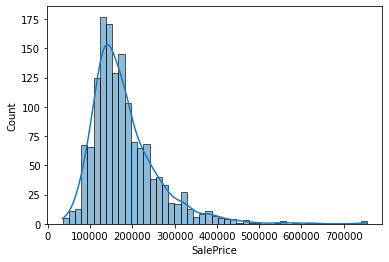

In [26]:
# Analysing target feature

sns.histplot(final['SalePrice'], kde=True)
plt.show()

### Building ML models

In [72]:
# Split the train and test data

final_new = final[final['SalePrice'].notna()]
data_to_predict = final[final['SalePrice'].isnull()]

x = final_new.drop("SalePrice", axis=1)
y = np.log(final_new["SalePrice"])

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.3, random_state=42)

####  Model 1 -> XGBoost

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

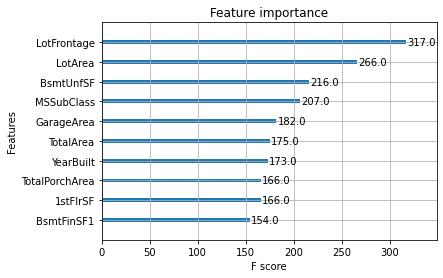

In [55]:
# Building the model 1 - XGBoost

import xgboost
xgb = xgboost.XGBRegressor(objective="reg:squarederror")
xgb.fit(xtrain, ytrain)
xgboost.plot_importance(xgb, max_num_features=10)

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ypred = np.exp(xgb.predict(xtest))
print("RMSE:", sqrt(mean_squared_error(ytest, ypred)))
print("mean", np.exp(ytrain).mean())

RMSE: 195308.04387418486
mean 181312.69275929543


#### Model 2 -> Lightbgm

In [30]:
# Model 2 - lightbgm

!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2807
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 149
[LightGBM] [Info] Start training from score 12.028893


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

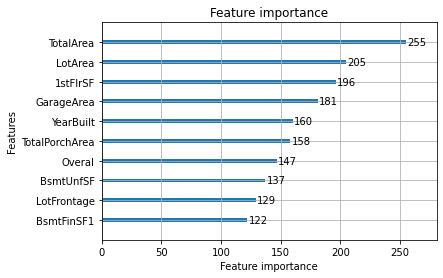

In [31]:
import lightgbm
lgb = lightgbm.LGBMRegressor(objective="root_mean_squared_error")
lgb.fit(xtrain, ytrain)
lightgbm.plot_importance(lgb, max_num_features=10)

In [32]:
ypred2 = np.exp(xgb.predict(xtest))
print("RMSE:", sqrt(mean_squared_error(ytest, ypred2)))

RMSE: 195308.04387418486


In [33]:
from sklearn.preprocessing import MinMaxScaler
lgb_imp = pd.DataFrame(dict(lgbm = lgb.feature_importances_), index=lgb.feature_name_)
xgb_imp = pd.DataFrame(dict(xgbm = xgb.feature_importances_), index=xgb.feature_names_in_)

importances = pd.concat([lgb_imp, xgb_imp], axis=1)
min_max = MinMaxScaler((0.1,1))

importances['cross'] = min_max.fit_transform(importances[['lgbm']]) * min_max.fit_transform(importances[['xgbm']])
sorted_feat = importances.sort_values(by='cross', ascending=False).reset_index()
sorted_feat

,index,lgbm,xgbm,cross
0,TotalArea,255,0.051486,0.332979
1,Overal,147,0.067535,0.250998
2,GarageCars,33,0.198890,0.216471
3,KitchenQual_Ex,13,0.179819,0.133293
4,YearBuilt,160,0.020748,0.128878
...,...,...,...,...
146,GarageType_None,0,0.000000,0.010000
147,GarageCond_None,0,0.000000,0.010000
148,BsmtCond_TA,0,0.000000,0.010000
149,GarageFinish_None,0,0.000000,0.010000


In [34]:
remove_cols = sorted_feat['index'].tail(120).tolist()

x2 = x.drop(remove_cols, axis=1)
x2.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,Neighborhood_Rare,Condition1_Norm,Foundation_PConc,BsmtQual_Ex,CentralAir_N,KitchenQual_Ex,KitchenQual_Gd,Functional_Rare,SaleCondition_Abnorml,SaleCondition_Normal
0,60.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,150.0,856.0,854.0,...,0,1,1,0,0,0,1,0,0,1
1,20.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,284.0,1262.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,60.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,434.0,920.0,866.0,...,0,1,1,0,0,0,1,0,0,1
3,70.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,540.0,961.0,756.0,...,1,1,0,0,0,0,1,0,1,0
4,60.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,490.0,1145.0,1053.0,...,1,1,1,0,0,0,1,0,0,1


#### Model 3 -> XGboost with new features

In [67]:
# Model 3 -> Xgboost with new features

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2,y, test_size=0.3, random_state=42)

import xgboost
xgb2 = xgboost.XGBRegressor(objective="reg:squarederror")

from sklearn.model_selection import GridSearchCV

params = {"booster": ['gbtree','gblinear'],
          "learning_rate": [0.08, 0.1, 0.12],
          "n_estimators": [50,100,150]}

gscv = GridSearchCV(estimator=xgb2, param_grid=params, cv=3, scoring='neg_mean_squared_error')
gscv.fit(xtrain2,ytrain2)
print("Best params:", gscv.best_params_)

Best params: {'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 100}


In [36]:
xgb_new = xgboost.XGBRegressor(**gscv.best_params_)
xgb_new.fit(xtrain2, ytrain2)

ypred3 = np.exp(xgb_new.predict(xtest2))
print("RMSE:", sqrt(mean_squared_error(ytest2, ypred3)))

RMSE: 193718.13985744168


#### Model 4 -> Linear Regression

In [37]:
# Model 4 -> Linear Regression (Ridge)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha_value = {"alpha":[0.001,0.01,0.02,0.03,0.04, 0.05, 0.06, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}

gscv2 = GridSearchCV(Ridge(), alpha_value, cv=3, scoring='neg_mean_squared_error')
gscv2.fit(xtrain2,ytrain2)
print("Best params:", gscv2.best_params_)

Best params: {'alpha': 8}


In [38]:
lr = Ridge(**gscv2.best_params_)
lr.fit(xtrain2, ytrain2)

ypred4 = np.exp(lr.predict(xtest2))
print("RMSE:", sqrt(mean_squared_error(ytest2, ypred4)))

RMSE: 191753.98957997345


In [39]:
!pip install sklego

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [40]:
from sklego.linear_model import LADRegression

#### Model 5 -> Voting regressor

In [66]:
# Model 5 -> Combining models -> Voting regressor

models = pd.DataFrame()
models['xgb'] = xgb_new.predict(xtest2)
models['lr'] = lr.predict(xtest2)

weightage = LADRegression().fit(models, ytest2).coef_
pd.DataFrame(weightage, index=models.columns, columns=['weightage'])

wt = LADRegression().fit(models, ytest2)
wt.coef_

array([0.69540146, 0.29729381])

In [69]:
from sklearn.ensemble import VotingRegressor

voting = VotingRegressor(estimators=[('xgb', xgb_new),
                                     ('lr', lr)], weights=weightage)
voting.fit(xtrain2, ytrain2)
voting_pred = np.exp(voting.predict(xtest2))

print("RMSE:", sqrt(mean_squared_error(ytest2, voting_pred)))

RMSE: 192730.2905579621


In [43]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=42)

for train_index, test_index in cv.split(x2,y):
    xtrain_fold, xtest_fold = x2.iloc[train_index], x2.iloc[test_index]
    ytrain_fold, ytest_fold = y.iloc[train_index], y.iloc[test_index]
    
    voting.fit(xtrain_fold, ytrain_fold)
    voting_pred = np.exp(voting.predict(xtest_fold))
    print("RMSE:", sqrt(mean_squared_error(ytest_fold, voting_pred)))

RMSE: 192730.2905579621
RMSE: 194438.14030543872
RMSE: 192490.48764745184
RMSE: 199949.85439649085


#### Model 6 -> Bagging regressor

In [44]:
# Model 6 -> Bagging regressor

from sklearn.ensemble import BaggingRegressor
bagging_regressor = BaggingRegressor(xgb2, n_estimators=10, random_state=42, max_samples=0.8)
bagging_regressor.fit(xtrain2, ytrain2)

ypred6 = np.exp(bagging_regressor.predict(xtest2))
print("RMSE:", sqrt(mean_squared_error(ytest2, ypred6)))

RMSE: 191980.57083519435


### Model Prediction

In [73]:
data_to_predict = final[final['SalePrice'].isnull()]

xt = data_to_predict.drop("SalePrice", axis=1)

In [74]:
xt_new = xt.drop(remove_cols, axis=1)
xt_new.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,...,Neighborhood_Rare,Condition1_Norm,Foundation_PConc,BsmtQual_Ex,CentralAir_N,KitchenQual_Ex,KitchenQual_Gd,Functional_Rare,SaleCondition_Abnorml,SaleCondition_Normal
1460,20.0,80.0,11622.0,1961.0,1961.0,0.0,468.0,270.0,896.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1461,20.0,81.0,14267.0,1958.0,1958.0,108.0,923.0,406.0,1329.0,0.0,...,0,1,0,0,0,0,1,0,0,1
1462,60.0,74.0,13830.0,1997.0,1998.0,0.0,791.0,137.0,928.0,701.0,...,0,1,1,0,0,0,0,0,0,1
1463,60.0,78.0,9978.0,1998.0,1998.0,20.0,602.0,324.0,926.0,678.0,...,0,1,1,0,0,0,1,0,0,1
1464,120.0,43.0,5005.0,1992.0,1992.0,0.0,263.0,1017.0,1280.0,0.0,...,1,1,1,0,0,0,1,0,0,1


In [79]:
# Prediction using ridge model

ypred_final = np.exp(lr.predict(xt_new))
ypred_final

array([109256.25874915, 149625.44750881, 178645.22579691, ...,
       174099.96713592, 118272.51749271, 244351.91001421])